# Анализ Тестов в Приложении Доставки

## Описание

Приложение по доставке готовых продуктов проводило два теста для улучшения пользовательского опыта. Необходимо проверить результаты этих тестов и сделать выводы на основе статистических тестов.

### Эксперимент 1: Разрешение фотографий блюд

Первый тест направлен на определение влияния разрешения фотографий блюд на количество заказов. Пользователям показывались изображения блюд в трех различных форматах:
- Прямоугольные 16:9
- Квадратные
- Прямоугольные 12:4

### Эксперимент 2: Обновление кнопки заказа

Второй тест оценивает влияние изменения дизайна кнопки заказа на количество заказов. Пользователи были разделены на две группы:
- Старая версия кнопки (control)
- Новая версия кнопки (test)

Коллега предположил, что среди групп могут быть значительные различия. Необходимо проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

### Описание данных

*Данные для Эксперимента 1*:

- `id` – идентификатор клиента в эксперименте
- `group` – формат изображения (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- `events` – количество заказанных блюд за период

*Данные для Эксперимента 2*:

- `id` – идентификатор клиента в эксперименте
- `segment` – сегмент (high/low)
- `group` – версия кнопки (control – старая версия, test – новая версия)
- `events` – количество заказанных блюд за период

## Задачи

1. Проверить, есть ли статистически значимые различия в количестве заказов между группами с разными форматами изображений.
2. Проверить, есть ли статистически значимые различия в количестве заказов между группами с разными версиями кнопок заказа.
3. Сделать выводы на основе результатов тестов и предложить рекомендации.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as ss
import statsmodels.formula.api as smf 
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import pingouin as pg

import requests
from urllib.parse import urlencode

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

In [2]:
def url_ydisk (url):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url    

# Загрузка данных

In [22]:
picture = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/iRcyB5PS8JB1lw'))

In [23]:
picture.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [24]:
picture.group.unique()

array(['A', 'B', 'C'], dtype=object)

In [25]:
picture.isna().sum()

id        0
group     0
events    0
dtype: int64

In [26]:
picture.group.value_counts()

A    10000
C    10000
B    10000
Name: group, dtype: int64

In [27]:
button =  pd.read_csv(url_ydisk('https://disk.yandex.ru/d/NqeZSGmq5O3iFw'))

In [28]:
button.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [29]:
button.group.unique()

array(['test', 'control'], dtype=object)

In [30]:
button.isna().sum()

id         0
group      0
segment    0
events     0
dtype: int64

In [31]:
button.group.value_counts()

control    50000
test       50000
Name: group, dtype: int64

# Эксеримент 1: формат фотографий

Нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

## Проверка стат допущений

Имеются 3 группы - имеет смысл воспользоваться статистическим тестом ANOVA для сравнения средних. Однако, для начала проверим дисперсии групп и нормальность распределений.

Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [35]:
pg.homoscedasticity(data=picture, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


p-value > 0.05 - не отклоняем нулевую гипотезу. Слеловательно, дисперсии групп гомогенны.

Также убедимся, что данные распределены нормально.


In [36]:
pg.normality(data=picture, dv="events", group="group", method = "normaltest")

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


Дополнительно посмотрим на qq-plotы.

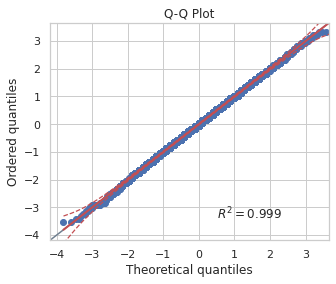

In [37]:
pg.qqplot(picture.query("group == 'A'").events)

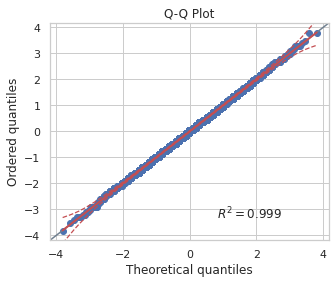

In [38]:
pg.qqplot(picture.query("group == 'B'").events)

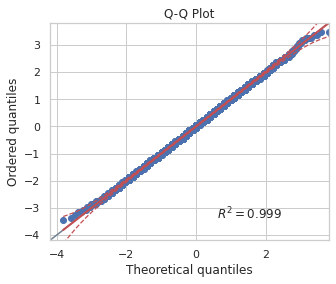

In [39]:
pg.qqplot(picture.query("group == 'C'").events)

В ходе неоднократной проверки пришли к выводу, что переменные распределены нормально.

Для сравнения средних я использую **однофакторный дисперсионный анализ**. 

Нулевая гипотеза: различия между средними значениями групп являются статистически незначимыми.

## Однофакторный ANOVA

In [41]:
#scipy
ss.f_oneway(picture.query("group == 'A'").events, 
            picture.query("group == 'B'").events, 
            picture.query("group == 'C'").events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [42]:
#pingouin
pg.anova(data=picture, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


**Вывод**: p-value < 0.05 → различия между средними значениями групп являются статистически значимыми.

Теперь используем критерий Тьюки и определим, **между какими группами** есть статистически значимые различия. 

In [43]:
pg.pairwise_tukey(data=picture, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


**Вывод**: p-tukey < 0 для каждых сравниваемых пар → существует статистически значимое различие между группами.

Также с помощью столбца `diff` отметим:
- группа А меньше группы В в среднем на 8 покупок
- группа А больше группы С в среднем на 2 покупки
- группа В больше группы С в среднем на 10 покупок

Также важно заметить, что у **группы В среднее значение наибольшее**. 

Text(0, 0.5, 'Число покупок')

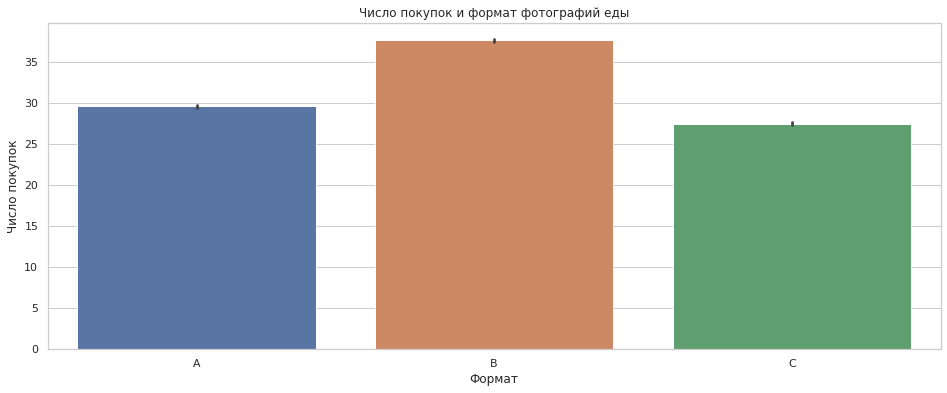

In [44]:
sns.barplot(x = 'group', y = 'events', data = picture)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('Формат')
plt.ylabel('Число покупок')

Text(0, 0.5, 'Число покупок')

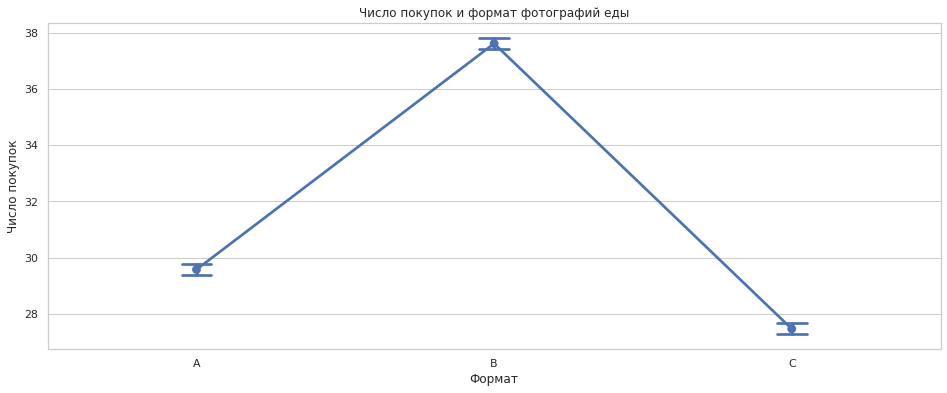

In [45]:
sns.pointplot(x = 'group', y = 'events', data = picture, capsize = .1)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('Формат')
plt.ylabel('Число покупок')

На графиках видно, что число покупок формата В статистически выше, чем в А и С. 

## Вывод по первому эксперименту: 

Таким образом, рекомендуется использовать картинки формата B (квадратные).


# Эксперимент 2: кнопка заказа

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Итак, имеется две группы (test/control) и два фактора (high, low) -> воспользуюсь **многофакторным дисперсионным анализом**.

Для начала визуализируем распределение `events` для контрольной и тестовой групп.

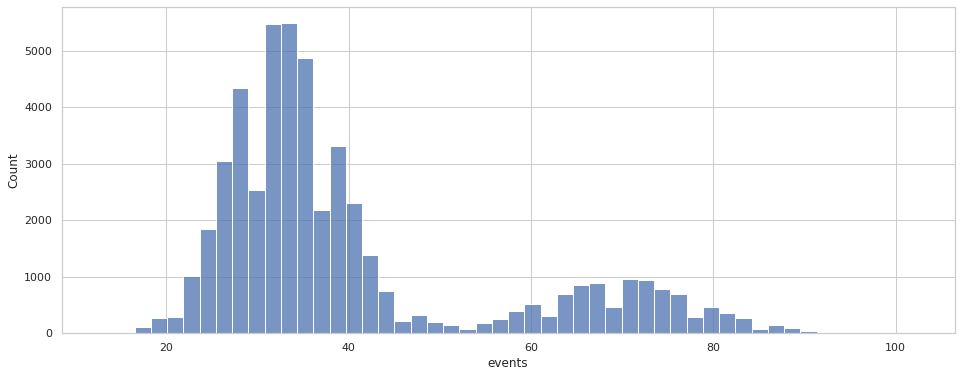

In [46]:
sns.histplot(button.query("group=='test'").events, bins=50)

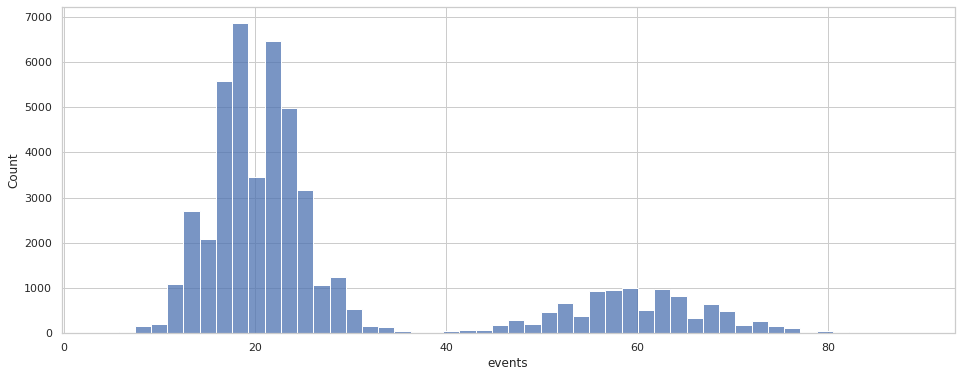

In [47]:
sns.histplot(button.query("group=='control'").events, bins=50)

Посчитаем среднее, медиану и стандартное отклонение `events` в разбивке по группе и по сегменту пользователя. 

In [48]:
button.groupby(['segment', 'group']).agg({'events':["mean", "median", "std"]}).round(2)

events             
                  mean median   std
segment group                      
high    control  59.97   60.0  7.81
        test     69.94   70.0  8.40
low     control  20.03   20.0  4.47
        test     33.03   33.0  5.72

Визуализация для низкого сегмента для обоих групп (наглядное различие по распределению):

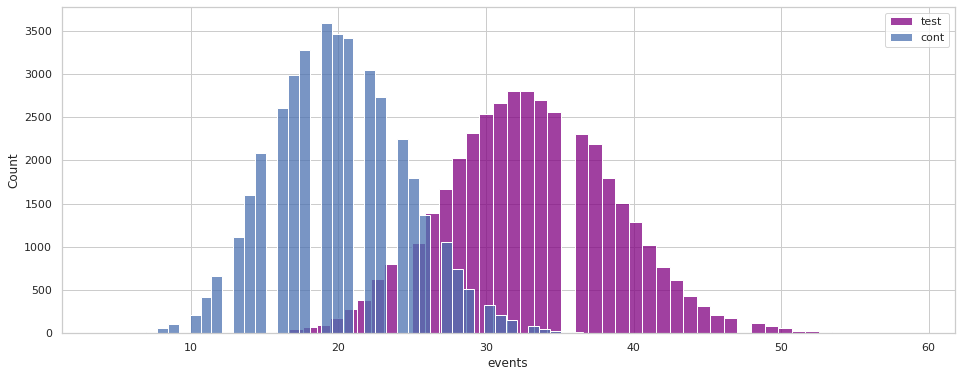

In [49]:
sns.histplot(button.query("segment == 'low' & group=='test'").events, label='test', color='purple', bins=50)
sns.histplot(button.query("segment == 'low' & group=='control'").events, label='cont', bins=50)
plt.legend()

Визуализация для высокого сегмента для обоих групп:

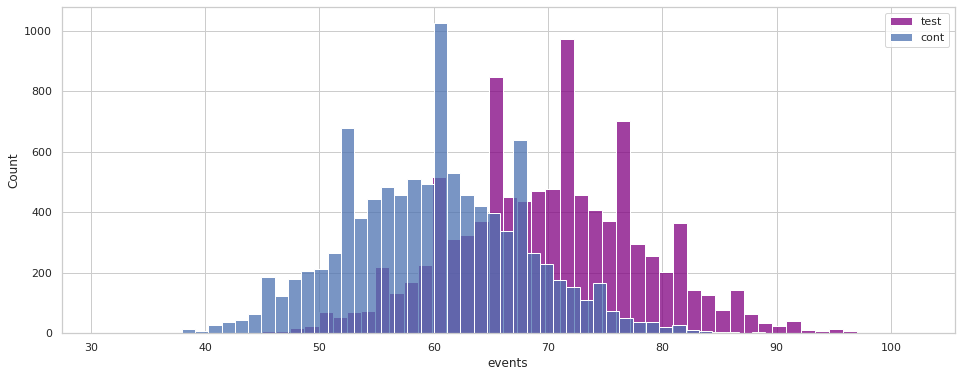

In [50]:
sns.histplot(button.query("segment == 'high' & group=='test'").events, label='test', color='purple', bins=50)
sns.histplot(button.query("segment == 'high' & group=='control'").events, label='cont', bins=50)
plt.legend()

## Многофакторный ANOVA

Необходимо проверить эффект нескольких переменных – `group` и `segment` на `events`, с взаимодействием факторов.

In [61]:
#statsmodels
#model = smf.ols(formula='events ~ segment + group + segment:group', data=button).fit()
model_interact = smf.ols("events ~ C(segment)*C(group)", data=button).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


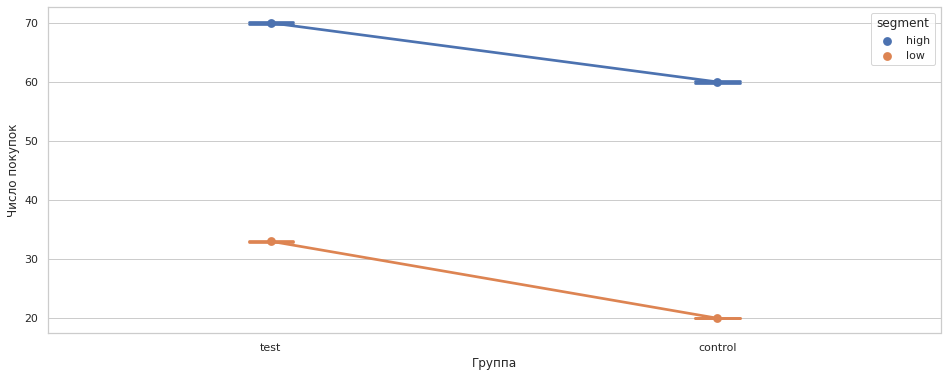

In [64]:
sns.pointplot(x = 'group', y = 'events', hue='segment', data = button, capsize = .1)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

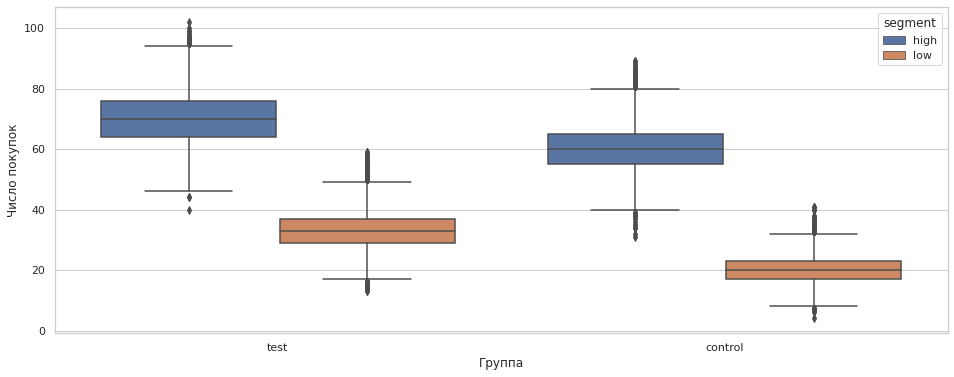

In [65]:
sns.boxplot(x = 'group', y = 'events', hue='segment', data = button)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

Из графиков видно, что в тестовой группе покупок было больше, чем в контрольной.

Используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

Для последующих сравнений между группами можно проделать следующую операцию: соединить колонки `group` и `segment` в `combination`, чтобы потом передать в аргумент `groups` в pairwise_tukey.

In [73]:
button['combination'] = button.group + ' \\ ' + button.segment

In [74]:
#Критерий Тьюки
pg.pairwise_tukey(data=button, dv="events", between="combination")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control \ high,control \ low,59.970800,20.031575,39.939225,0.065432,610.391461,0.001,6.824282
1,control \ high,test \ high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.001,-1.703109
2,control \ high,test \ low,59.970800,33.025925,26.944875,0.065432,411.798717,0.001,4.603981
3,control \ low,test \ high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.001,-8.527429
4,control \ low,test \ low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.001,-2.220314
5,test \ high,test \ low,69.938500,33.025925,36.912575,0.065432,564.135148,0.001,6.307128


По таблице можно сделать некоторые выводы:
- Разница между control/high и test/high составила около 10
- Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13
- **Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой**


## Вывод по второму эксперименту: 

Фактор `group` оказался **значимым**, фактор `segment` – **значимым**, их взаимодействие – **значимо**. Судя по графикам, для всех групп среднее значение `events` **увеличилось**. 

Рекомендуется внедрить новый формат кнопки заказа.